In [1]:
#import optuna
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import optuna.integration.lightgbm as lgb
import lightgbm as lgb
#from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV,  cross_val_score    
import shap
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns


c:\Users\beego\anaconda3\envs\AppML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import 20-bin gridded dataset
#metadata_file = "metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
#metadata_file = "n0_wpics_metadata19_hmineq0.0_tmin20050000_mean_grid_20-1.csv" # with pictures without 0 20grid
metadata_file = r"C:\Users\beego\Desktop\Visualcode_Courses\STEMACADEMY\Gletsjer\Gletscher data\data\.ipynb_checkpoints\metadata19_hmineq0.0_tmin20050000_mean_grid_20-checkpoint.csv" # without 0 and pictures b 20grid
#metadata_file = 'n0_metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv' # 100grid without 0 and pictures

In [3]:
df = pd.read_csv(metadata_file)

# Filter the data where 'THICKNESS' is smaller than 1000
#df = data[data['THICKNESS'] < 1000]

# Display the shape of the filtered dataframe to check the number of rows and columns
print(df.shape)
#print(data.shape)

(81290, 58)


In [4]:
class CFG:
    min_thick_value_train = 1.0 # Set this to get rid of measures less than 1 m 

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'


In [5]:
# Import the training dataset
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)
# Remove nans
#glathida_rgis = glathida_rgis.dropna()
# Filter out measurements less than 1 meter
#glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# Lets see how many measurements we have in each region
print(glathida_rgis['RGI'].value_counts())

# Add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']


# Assign the truth and input value
X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

# Split into testing and training
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

RGI
5.0     32413
3.0     16148
4.0      8796
7.0      7147
11.0     5986
19.0     4676
8.0      2118
1.0      1839
13.0      880
17.0      668
12.0      223
16.0      139
10.0      136
2.0       121
Name: count, dtype: int64


In [6]:
# Inside the objective function
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 0.5),  # Increase regularization
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 0.5),  # Increase regularization
        'num_leaves': trial.suggest_int('num_leaves', 128, 2048),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1
    }
    
   
    # run the model, fit and predict 
    model = lgb.LGBMRegressor(**param)

    # Fit model
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(100, first_metric_only=True)],  # Use 'l1' instead of 'mae'
        #verbose=False
    )
    
    y_preds = model.predict(X_valid) # num_iteration=model.best_iteration)
    
    rmse = mean_squared_error(y_valid, y_preds, squared=False)
    MAE = mean_absolute_error(y_valid, y_preds)
    R2 = r2_score(y_valid, y_preds)
    
    return MAE


In [7]:
# # create a study and start the optimization process:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

In [8]:
best_params = {'lambda_l1': 0.1296388844954259, 'lambda_l2': 0.444904118652734, 'num_leaves': 1786, 'feature_fraction': 0.8392922978649594, 'bagging_fraction': 0.941056644727271, 'bagging_freq': 5, 'min_child_samples': 22}

In [9]:
# # Retrieve best hyperparameters

# print("Best hyperparameters: ", best_params)
# print("Best MAE: ", study.best_value)


In [10]:


# Load data again for final training
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_train, y_train), (X_valid, y_valid)]

# Train final model with the best hyperparameters
# best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'mae'
best_params['verbosity'] = -1

# Train the final model with the best hyperparameters
model = lgb.LGBMRegressor(**best_params)
gbm = model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='mae',
    #verbose=False,
    callbacks=[lgb.early_stopping(5, first_metric_only=True)]
)

#model = lgb.LGBMRegressor(**best_params)
# gbm = model.fit(X_train, y_train, eval_set=eval_set) #early_stopping_rounds=100, verbose_eval=False)

# Predict and calculate RMSE on validation set
preds = gbm.predict(X_valid) #num_iteration=gbm.best_iteration)
rmse = mean_squared_error(y_valid, preds)#, squared=False)
MAE = mean_absolute_error(y_valid, preds)
R2 = r2_score(y_valid, preds)
#print(f"Validation RMSE: {rmse}")
#print('This is the typical magnitude of error between the predicted values and the actual values, in the same units as your target variable.')
#print(f"Validation MAE: {MAE}")
print(f"Validation R2: {R2}")

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l1: 4.68418	valid_1's l1: 19.7036
Evaluated only: l1
Validation R2: 0.9443805977328247


In [ ]:
#  #################### SHAP ####################
# # Compute SHAP values
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_valid)

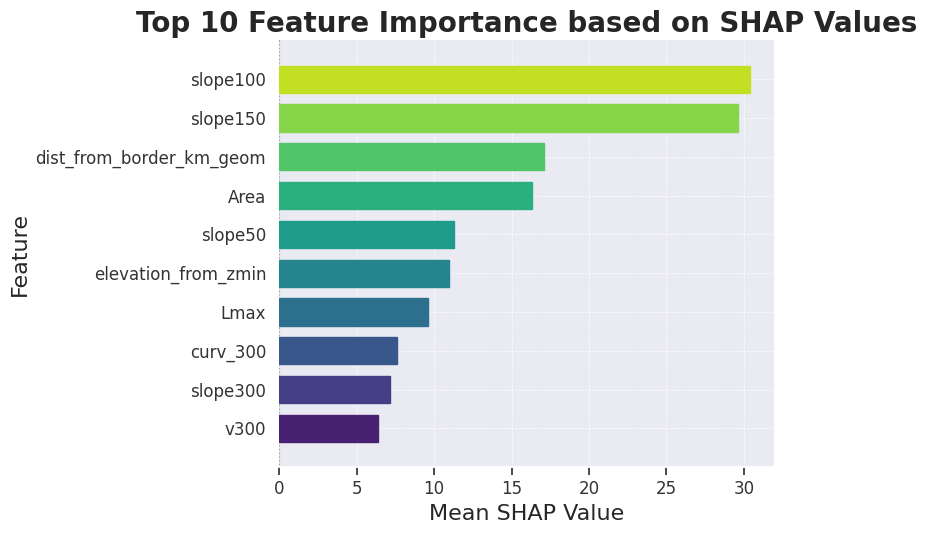

In [ ]:
# sns.set_theme()

# mean_abs_shap_values = pd.DataFrame(np.abs(shap_values)).mean(axis=0)
# feature_importance = pd.DataFrame(list(zip(X_valid.columns, mean_abs_shap_values)), columns=['Feature', 'SHAP Value'])
# feature_importance = feature_importance.sort_values(by='SHAP Value', ascending=False)
# top_10_features = feature_importance.head(10)['Feature'].tolist()
# # Filter the SHAP values and the validation set to only include the top 10 features
# shap_values_top_10 = shap_values[:, feature_importance.index[:10]]
# X_valid_top_10 = X_valid[top_10_features]


# # Create the SHAP summary plot with enhanced aesthetics
# plt.figure(figsize=(12, 8))
# shap.summary_plot(shap_values_top_10, X_valid_top_10, plot_type='bar', show=False)

# # Customize the plot
# plt.title('Top 10 Feature Importance based on SHAP Values', fontsize=20, weight='bold')
# plt.xlabel('Mean SHAP Value', fontsize=16)
# plt.ylabel('Feature', fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.tight_layout()

# # Add custom colors to the bars
# bars = plt.gca().patches
# colors = sns.color_palette("viridis", len(bars))
# for bar, color in zip(bars, colors):
#     bar.set_color(color)

# plt.savefig('SHAP.png')
# # Show the plot
# plt.show()

# Plotting nicely

In [11]:
def evaluation_plot(estimator, y_test, y_pred):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Plot the residuals histogram
    ax1.hist(residuals, bins=100, color='blue')
    ax1.set_title('Distribution of Residuals', size = 16)
    ax1.set_xlabel('Residuals', size = 13)
    ax1.set_ylabel('Count', size = 13)
    
    # Plot the relative errors histogram
    ax2.hist(relative_errors, bins=100, color='blue')
    ax2.set_title('Distribution of Relative Errors', size = 16)
    ax2.set_xlabel('Relative Prediction Error', size = 13)
    ax2.set_ylabel('Count', size = 13)
    ax2.set_xlim(-1.5, 1.5)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure to a file
    #fig.savefig('residuals_and_relative_errors.png')
    
    # Show the plot
    plt.show()
    
    

    '''# Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins='auto', color='blue')
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Count')
    #ax1.set_xlim()
    
    ax2.hist(relative_errors, bins='auto')
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()
    
    fig.savefig('Distribution of Relative Errors (LightGBM).png')'''
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label [m]', size = 13)
    plt.ylabel('Prediction [m]', size = 13)
    plt.title('Thickness Diversion (LightGBM)', size = 16)
    plt.legend()
    plt.savefig('Diversion (LightGBM).png')
    plt.show()
    

    '''# Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    plt.show()'''

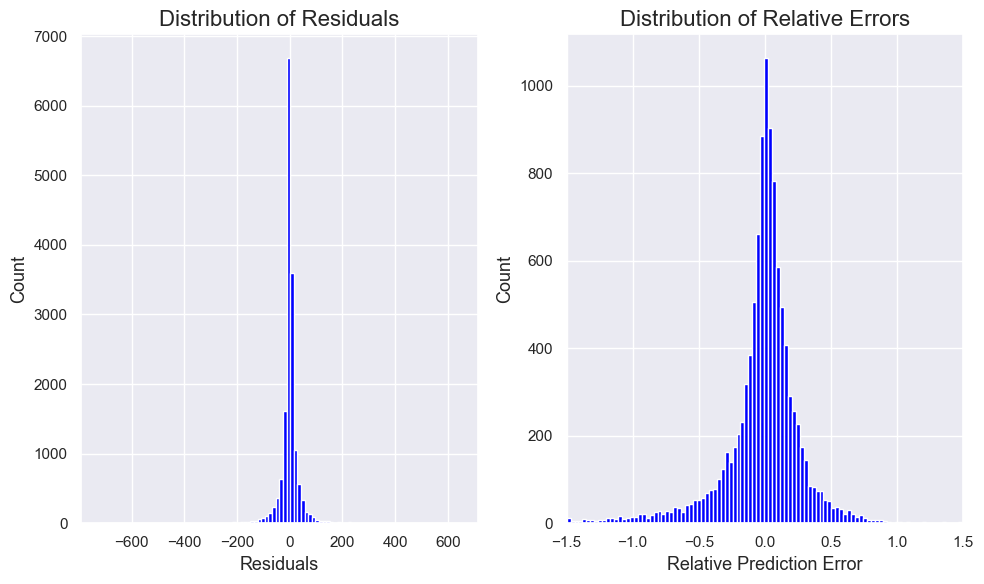

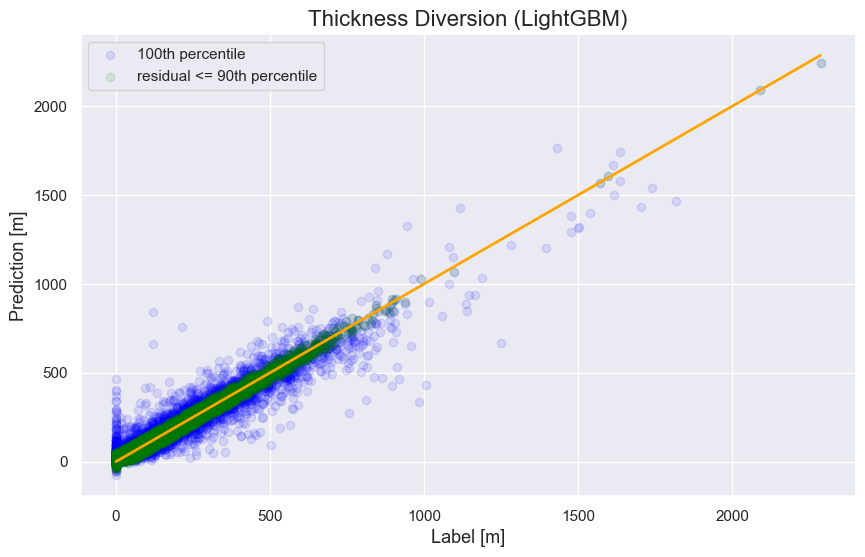

In [12]:
# plot evaluation
sns.set_theme()
evaluation_plot(model, y_valid, preds)

# Overfitting test

In [ ]:
def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")

    # if I want to plot evolution of training and validation metrics I can either use in build function like in tensorflow or create a list
    # of training scores and validation scores depending on n_estimators/epochs --- but this need computational power --- probably


In [ ]:
test_overfitting(model, mean_absolute_error, X_train, y_train, X_valid, y_valid, prob=False)

Training Accuracy: 4.5092
Test Accuracy: 21.5049


In [ ]:
# Perform k-fold cross-validation (e.g., k=5)
k=5
cv_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
print("Cross-Validation: %.4f +- %.4f" %(-cv_scores.mean(), cv_scores.std()))

Cross-Validation: 22.9377 +- 0.2924


In [ ]:
0.2924/np.sqrt(5)

0.1307652553241877

## MY OWN CODE BELOW

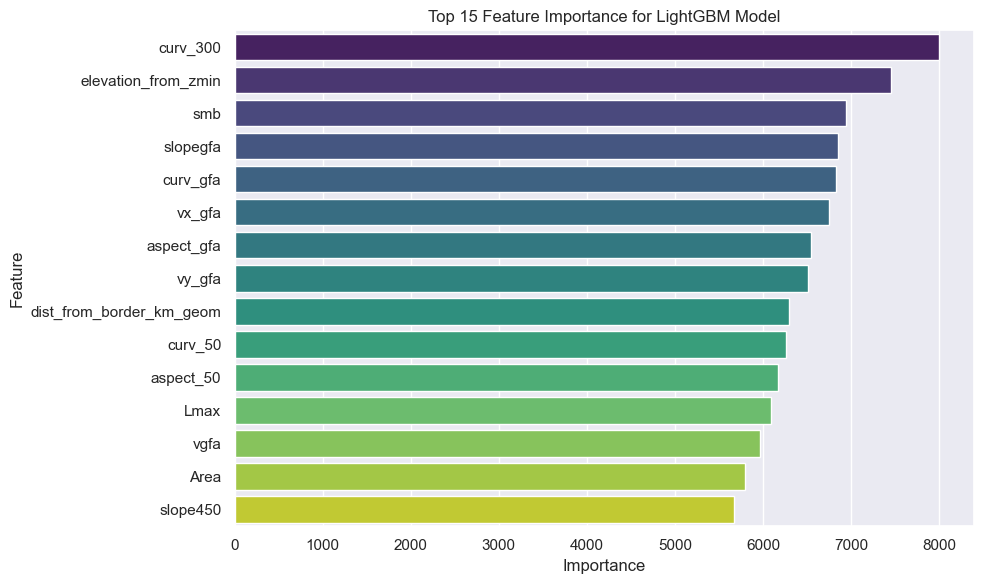

In [14]:
# Calculate and plot the top 15 most important features for the trained LightGBM model
importances = gbm.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot the top 15 feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 15 Feature Importance for LightGBM Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [24]:
Renaming = {'curv_300' : 'haeldning_300m', 'elevation_from_zmin' : 'elevation', 'smb' : 'mass_balance', 'curv_gfa' : 'haeldning_adaptiv', 'vx_gfa' : 'hastighed_x', 'aspect_gfa' : 'retning', 'vy_gfa' : 'hastighed_y', 'dist_from_border_km_geom' : 'afstand_til_kant_km', 'Area' : 'areal'}


In [ ]:
# Now could you save a new csv file which contain only the columns in the disctionary 'Renaming'. Also could you make the column names in the new csv files be the ones in the dictionary. 

SyntaxError: invalid syntax (3040571621.py, line 1)

0          6.000000
1         11.000000
2         13.000000
3          7.000000
4          6.000000
            ...    
81285    342.000000
81286    353.428571
81287    367.000000
81288    357.285714
81289    307.875000
Name: THICKNESS, Length: 81290, dtype: float64

In [26]:
# Create a new DataFrame with selected columns and renamed headers
renamed_df = X[list(Renaming.keys())].rename(columns=Renaming)

# Add the target variable 'y' as the final column
renamed_df['gletsjer_dybde'] = y

# Save the new DataFrame to a CSV file
renamed_df.to_csv('gletsjer_data_ny_0.csv', index=False)
print("New dataset saved as 'gletsjer_data_ny_0.csv'")

New dataset saved as 'gletsjer_data_ny_0.csv'


In [27]:
# Check for NaN entries in the dataset 'gletsjer_data_ny_0.csv'
dataset = pd.read_csv('gletsjer_data_ny_0.csv')
nan_entries = dataset.isna().sum().sum()
if nan_entries > 0:
    print(f"The dataset contains {nan_entries} NaN entries.")
else:
    print("The dataset does not contain any NaN entries.")

The dataset does not contain any NaN entries.


In [31]:
best_params = {'lambda_l1': 0.1296388844954259, 'lambda_l2': 0.444904118652734, 'num_leaves': 1786, 'feature_fraction': 0.8392922978649594, 'bagging_fraction': 0.941056644727271, 'bagging_freq': 5, 'min_child_samples': 22}

In [32]:
# Create a simple LightGBM regression model using the dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import pandas as pd

# Load the dataset
dataset = pd.read_csv('gletsjer_data_ny_0.csv')

# Define features and target
X = dataset.drop(columns=['gletsjer_dybde'])
y = dataset['gletsjer_dybde']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple LightGBM model
model = lgb.LGBMRegressor(random_state=42, **best_params)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_valid)

# Evaluate the model
rmse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

RMSE: 2586.9959045249075
MAE: 25.176411994405587
R2 Score: 0.9133003722903034


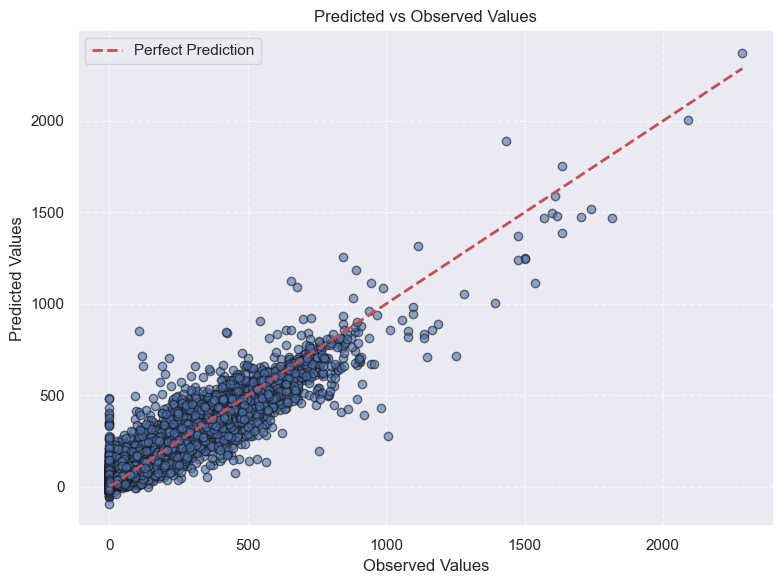

In [33]:
# Create a scatterplot for predicted vs observed values
import matplotlib.pyplot as plt

# Plot the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Predicted vs Observed Values')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

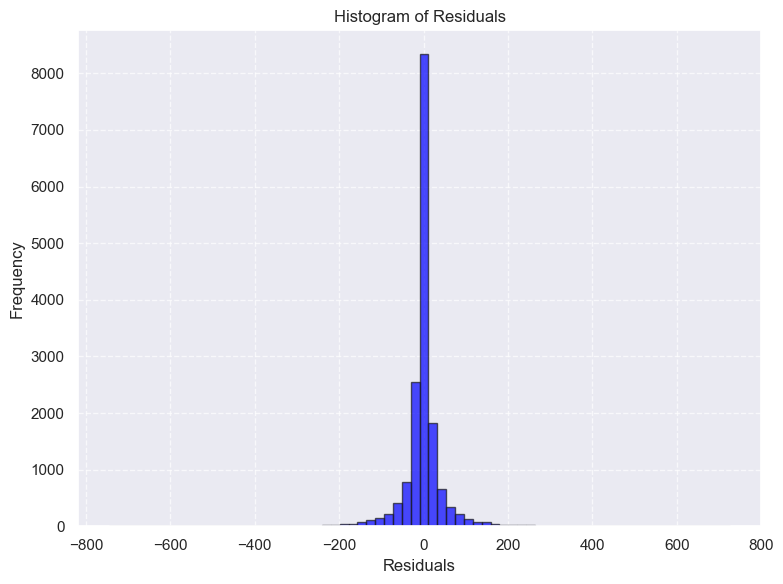

In [36]:
# Create a histogram of residuals
residuals = y_valid - y_pred

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=70, color='blue', alpha=0.7, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Spørgsmål: Skal vi have hele Majas pdf inde på hjemmesiden 
# eller udelukkende vejledning til at bruge den?